# Optimizing To-do List with Monte Carlo Simulations

If you have multiple tasks on your todo list, which should you do first? The first one on the list? The easiest one to do? The important ones first? Or should you have more elaborate ways to tackle them?
All this becomes a bit more interesting if you have limited time to complete our tasks. If you don’t have enough time, which ones should you tackle first and what is the strategy to use to optimise your time?
Obviously this depends greatly on what you want to optimise for – do you want to complete as many tasks as possible? Or complete as many high priority tasks as possible? Or complete as many tasks in time as possible?

## Modeling

Monte Carlo simulations is a good way to solve problems, we simply model the problem, generate random data and through run the simulations as many times as possible.

## The Model

We will model a task with the following attributes:
* Importance (weight)
* Due date
* Complexity (duration)
* Completion date

In [3]:
from recordtype import recordtype

Task = recordtype('Task', 'weight duration due done')

## Creating Tasks


In [4]:
import numpy as np

def create_tasks(num): 
    tasks = []
    distribution = np.round(np.random.exponential(5,10000))
    for i in range(num):
        weight = np.random.randint(1,100)
        due = np.random.choice(distribution)+1
        duration = np.random.randint(0,due)
        t = Task(weight=weight, duration=duration, due=due, done=0) 
        tasks.append(t)  
    return tasks

* The weight is simply a random number between 1 to 100, where the higher the number is, the more important the task is. `randint`, which uses a discrete uniform distribution is used to generate the random number
* The due date is another integer indicating the number of days away from the start of the simulation this task is due. Due dates in todo lists are mostly close to the current date, further away due dates are not as common. An exponential distribution, with a rate parameter (λ) value of 5 is used.
* The duration parameter for the task is how much time it will take to do that task, which is really the complexity of the task. The duration should be less than the due date, otherwise it’s an impossible task. A random integer between 1 and the due date is used
* The completion date or done attribute is set to 0 when the task is created and will be set to an integer that represents the amount of time that has passed since the simulation started, once the task is completed.

## Tallying up
The tally function takes in a list of completed tasks and a list of all tasks that were created for the simulation, and returns a tuple of 3 values:
* The number of tasks that have been completed
* The number of important tasks that have been completed
* The number of tasks that has been completed in time

In [5]:
def tally(completed_tasks, all_tasks):
    # percentage of tasks completed    
    completed = len(completed_tasks)/len(all_tasks)    

    # set the 75th percentile of all tasks based on weight
    # as the important tasks
    percentile = round(0.75 * len(all_tasks))
    important_tasks = sorted(all_tasks, key=lambda x: x.weight)[percentile:len(all_tasks)]

    # count how many important tasks have been completed
    overlap = 0
    for t in important_tasks:
        if t in completed_tasks:
            overlap += 1
    # the weight is the percentage of important tasks completed
    if len(important_tasks) > 0:
        important = overlap/len(important_tasks)
    else:
        important = 0

    # percentage of tasks that are completed in time
    intime_tasks = []
    for task in completed_tasks:
        if task.done <= task.due:
            intime_tasks.append(task)
    intime = len(intime_tasks)/len(all_tasks)
    
    return (completed, important, intime)

## Simulation

To simulate a lack of time, we add up the duration for all tasks and take a percentage of this total duration. This will be our deadline.

In [6]:
def duration(task): return task.duration

# run a single simulation
def simulate(ratio, *tasks):
    deadline = ratio * sum(list(map(duration, tasks)))
    completed_tasks = []
    elapsed_time = 0
    for task in tasks:
        elapsed_time += task.duration
        if elapsed_time <= deadline:
            task.done = elapsed_time
            completed_tasks.append(task)
        else:
            break
    
    return tally(completed_tasks, tasks)

## Monte Carlo

If we run the simulation just once then it’s not a Monte Carlo simulation. Monte Carlo simulations are about running simulations over and over again to solve a problem. To do this we will create a function called `run`.

This function is pretty straightforward. We run over a number of iterations the following steps:
* Create the tasks for simulation
* Simulate the execution of the tasks using a given algorithm
* Get the results and add them to a final list

Once we have the final set of data, we divide it over the number of iterations to get the final set of results for that particular algorithm.

In [7]:
def add(a, b): return tuple(map(lambda x, y: x + y, a, b))
def divide(a, b): return tuple([x/b for x in a])

# Run multiple iterations of the simulation 
def run(ratio, iterations, num, algorithm):
    results, final_results = (0,0,0), (0,0,0)

    for i in range(iterations):
        tasks = create_tasks(num)
        results = simulate(ratio, *tuple(algorithm(*tasks)))
        final_results = add(final_results, results)

    return divide(final_results, iterations)

# print results from running the simulation
def print_results(data):
    params = ("- tasks completed",
              "- important tasks completed",
              "- tasks completed in time")
    for d,p in zip(data, params):
        print("{0:s} : {1:3.2f}%".format(p.ljust(40, ' '), d*100)) 

## Todo Algorithms

The simulation is designed to test different todo strategies or algorithms to determine their effectiveness. The effectiveness of the algorithm is measured using 3 metrics:
* How many tasks are completed
* How many important tasks are completed
* How many tasks are completed in time

In [8]:
def as_they_come(*tasks):
    return tasks

def due_first(*tasks):
    return sorted(tasks, key=lambda x: x.due)

def due_last(*tasks):
    return sorted(tasks, key=lambda x: x.due, reverse=True)

def important_first(*tasks):
    return sorted(tasks, key=lambda x: x.weight, reverse=True) 

def easier_first(*tasks):
    return sorted(tasks, key=lambda x: x.duration)

def easier_important_first(*tasks):
    return sorted(tasks, key=lambda x: x.duration/x.weight)

def easier_due_first(*tasks):
    return sorted(tasks, key=lambda x: x.duration/x.due)

## Putting it all together

For the simulation, we will use the following parameters:
* The deadline is 50% of the total time to do all the tasks
* We will create 25 tasks per simulation
* We will run the simulation 20,000 times

Do as they come
- tasks completed                        : 48.51%
- important tasks completed              : 48.23%
- tasks completed in time                : 11.76%

Due tasks first
- tasks completed                        : 78.07%
- important tasks completed              : 77.76%
- tasks completed in time                : 29.28%

Due tasks last
- tasks completed                        : 18.40%
- important tasks completed              : 18.16%
- tasks completed in time                : 6.68%

Important tasks first
- tasks completed                        : 48.32%
- important tasks completed              : 99.41%
- tasks completed in time                : 11.75%

Easier tasks first
- tasks completed                        : 83.52%
- important tasks completed              : 83.16%
- tasks completed in time                : 46.70%

Easier important tasks first
- tasks completed                        : 78.29%
- important tasks completed              : 93.34%
- tasks completed in time    

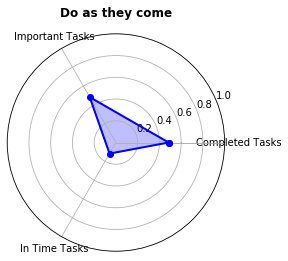

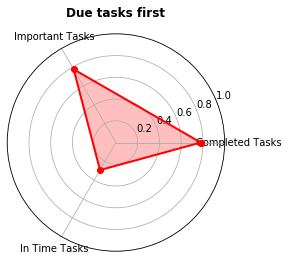

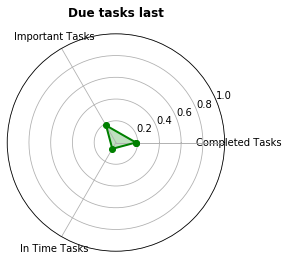

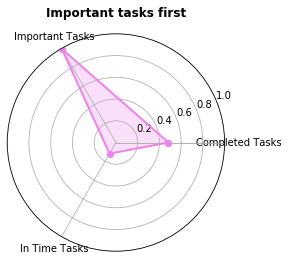

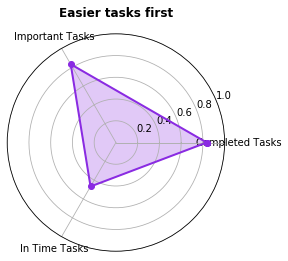

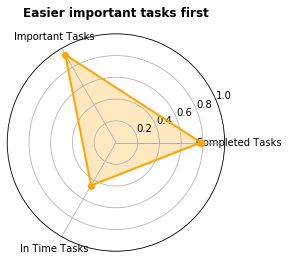

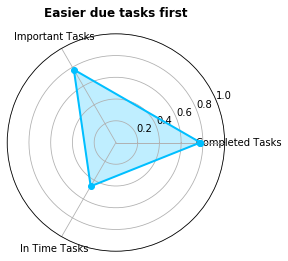

In [9]:
import matplotlib.pyplot as plt

def chart(data, title):
    labels=np.array(['Completed Tasks', 'Important Tasks', 'In Time Tasks'])
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))    
    
    colors = ['blue', 'red', 'green', 'violet', 'blueviolet', 'orange', 'deepskyblue']
    for d, t, c in zip(data, title, colors):
        fig=plt.figure()
        d=np.concatenate((d,[d[0]]))
        ax = fig.add_subplot(111, polar=True)
        ax.set_title(t, weight='bold', size='large')      
        ax.plot(angles, d, 'o-', linewidth=2, color=c)
        ax.fill(angles, d, alpha=0.25, color=c)
        ax.set_thetagrids(angles * 180/np.pi, labels)
        ax.set_ylim(0,1.0)
        ax.grid(True)

        
# deadline ratio
ratio = 0.5
# number of iterations to run
iterations = 20000
# no of tasks
num = 25

algorithms = (as_they_come,
              due_first,
              due_last,
              important_first,
              easier_first,              
              easier_important_first,
              easier_due_first)

labels = ("Do as they come", 
           "Due tasks first", 
           "Due tasks last",
           "Important tasks first", 
           "Easier tasks first", 
           "Easier important tasks first",
           "Easier due tasks first" )

data = []

# run the simulation for each algorithm and print out the results
for algo, label in zip(algorithms, labels):
    d = run(ratio, iterations, num, algo)
    print(label)
    print_results(d)
    data.append(d)
    print()

# also create a radar chart for each algorithm
chart(data, labels)

**Reference**

[Optimise your todo list with Monte Carlo simulations in Python](https://towardsdatascience.com/optimise-your-todo-list-with-monte-carlo-simulations-in-python-1682a8a5eb84)